In [30]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import math
import collections
import numpy as np

In [31]:
file_name = "syn_3"
attribute_key = "property_lt_20"

In [32]:
case_attribute_key = f'case:{attribute_key}'
case_id_key = "case:concept:name"

# df = pm4py.read_xes(f'../logs/{file_name}.xes')
df = pd.read_csv(f'../logs/{file_name}.{attribute_key}.csv')
df["time:timestamp"] = pd.to_datetime(df['time:timestamp'])
df["case:concept:name"] = df['case:concept:name'].astype(str)
df["concept:name"] = df['concept:name'].astype(str)


df = df.dropna(subset=[case_attribute_key]).reset_index() # filter empty rows

In [33]:
variants = pm4py.get_variants_as_tuples(df)
activities = {}

for (v, o) in variants.items():
    for a in v:
        activities[a] = activities.setdefault(a, 0) + o

activities = dict(sorted(activities.items(), key=lambda x: x[1], reverse=True))
activity_to_char = { k: chr(i) for i, (k, v) in enumerate(activities.items()) }
print(len(activity_to_char))

def trace_to_string(t):
    return "".join([ activity_to_char[a] for a in t ])

512


In [34]:
from rapidfuzz.distance import Levenshtein

def LD(A, B):
    return Levenshtein.distance(A, B)

def NGLD(A, B):
    ld = LD(A, B)
    return (2 * ld) / ((len(A) + len(B)) + ld)

In [35]:
def LNGLD(L1, L2, S1, S2):
    L1_string_log = { trace_to_string(k): v for k, v in L1.items() }
    L2_string_log = { trace_to_string(k): v for k, v in L2.items() if v > 0 }

    sum = 0
    for t1, n1 in L1_string_log.items():
        for t2, n2 in L2_string_log.items():
            sum += NGLD(t1, t2) * n1 * n2

    return sum / (S1 * S2)

In [36]:
def MMLNGLD(L1, L2, S1, S2):
    return ((1 - LNGLD(L1, L2, S1, S2)) + LNGLD(L1, L1, S1, S1) + LNGLD(L2, L2, S2, S2)) / 3

In [37]:
def cMMLNGLD(l1, l2, s1, s2, phi=3):

    d = MMLNGLD(l1, l2, s1, s2)

    full = sum([ [k] * v for k, v in l1.items() ] + [ [k] * v for k, v in l2.items() ], [])

    s = 0
    for i in range(phi):

        rs1 = [ full[math.floor(len(full) * r)] for r in np.random.random_sample((int(s1),)) ]

        l1_ = collections.Counter(rs1)
        l2_ = collections.Counter(full) - l1_

        d_ = MMLNGLD(l1_, l2_, s1, s2)

        s = s + d_

    return d / (s / phi)

In [38]:
attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)

In [39]:
df_gte_light = grouped.first() # initial gte group

# define absolute languages (counting the occurrence of cases)
# devide absoulte numbers by total number of cases later(!), otherwise every values has to be updated
language_lt = {}
language_gte = pm4py.stats.get_variants(df)

ds = []

t = time.time()

for pivot in tqdm(sorted_attribute_values[1:]):

    # find affected cases
    df_affected_light_idx = df_gte_light[df_gte_light[case_attribute_key] < pivot].index

    # remove affected cases from gte group
    df_gte_light.drop(df_affected_light_idx, inplace=True)

    # translate into full df
    df_affected = pd.concat([ df.loc[grouped.indices[i]] for i in df_affected_light_idx ])

    # update absoulte languages
    for tr, n in pm4py.stats.get_variants(df_affected).items():
        language_lt[tr] = language_lt.setdefault(tr, 0) + n
        language_gte[tr] = language_gte[tr] - n

    language_lt_size = sum(language_lt.values(), 0.0)
    language_gte_size = sum(language_gte.values(), 0.0)

    cmmlngld = cMMLNGLD(language_lt, language_gte, language_lt_size, language_gte_size)
        
    ds.append(cmmlngld)

t = time.time() - t

time.sleep(1)

print(f"time elapsed: {t}")

100%|██████████| 68/68 [01:40<00:00,  1.48s/it]


time elapsed: 100.73779654502869


In [40]:
# syn_3 property_lt_20: 256m 18.95s (single thread) / (lv: 125.84s) / (rf: 152.85s / 159.47s / 153.67)
# syn_2 property_lt_20: 15.76s (single thread) / (lv: 0.24s) / (rf: 257.88ms / 251.84ms / 267.80ms)
# syn_1 property_lt_20: 63.42ms (single thread) / (rf: 93.42ms / 74.00ms / 98.00ms)

In [41]:
# mmlnglds = [ (d + (2 - s1 - s2) / 2) / 2 for d, s1, s2 in zip(ds, s1s, s2s) ]

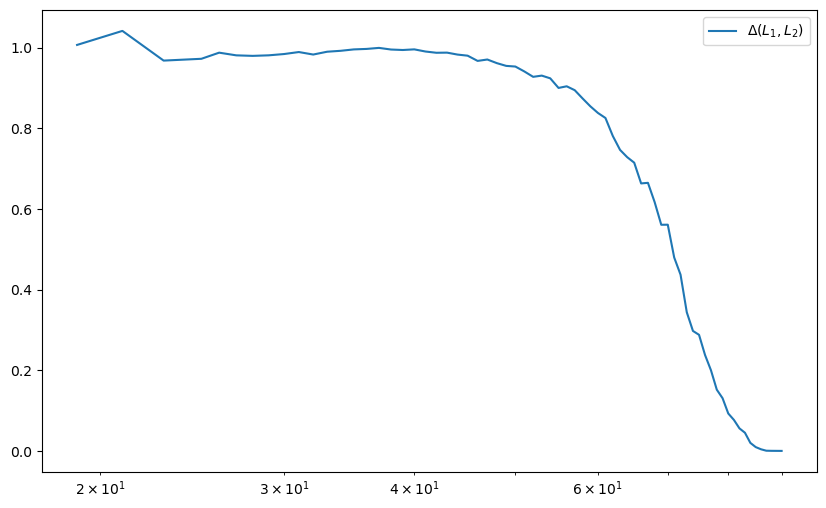

In [44]:
plt.figure(figsize=(10,6))

# plot mmlngld
plt.plot(sorted_attribute_values[1:], ds, label=r"$\Delta(L_1,L_2)$")
# plt.plot(sorted_attribute_values[1:], s1s, label=r"$\Delta(L_1,L_1)$")
# plt.plot(sorted_attribute_values[1:], s2s, label=r"$\Delta(L_2,L_2)$")
# plt.plot(sorted_attribute_values[1:], mmlnglds)
plt.xscale("log")
plt.legend()
# plt.savefig(f"out.mmlngld.{file_name}.{attribute_key}.png", bbox_inches="tight")

In [ ]:
# pd.DataFrame({"d": ds, "s1": s1s, "s2": s2s}).to_csv(f"out.mmlngld.{file_name}.{attribute_key}.csv", index=False, header=False)